In [167]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re

In [270]:
#load data set
listings = pd.read_csv('C:/Users/kevin/Desktop/Study/airbnb_data/listings.csv')
reviews = pd.read_csv('C:/Users/kevin/Desktop/Study/airbnb_data/reviews.csv')
calendar = pd.read_csv('C:/Users/kevin/Desktop/Study/airbnb_data/calendar.csv')

## Three Questions to Answer 
### 1. Does instant bookable impact number of review the listing receive ?

In [39]:
listings.review_scores_value.unique()

array([10., nan,  9.,  8.,  7.,  6.,  4.,  2.,  5.])

In [6]:
#fill na for review_scores_value with -1, making assumption that if missing review means new listing
listings['review_scores_value']=listings['review_scores_value'].fillna(-1)

In [27]:
instant_bookable_chart=(listings[listings.instant_bookable=='t'].groupby('review_scores_value').reviews_per_month.count()/listings[listings.instant_bookable=='t'].shape[0]).reset_index()
non_instant_bookable_chart=(listings[listings.instant_bookable=='f'].groupby('review_scores_value').reviews_per_month.count()/listings[listings.instant_bookable=='f'].shape[0]).reset_index()


In [58]:
l=list(set(instant_bookable_chart.review_scores_value.append(non_instant_bookable_chart.review_scores_value)))
l.sort()

C:\Users\kevin\AppData\Local\Temp\ipykernel_5396\3067933759.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  l=list(set(instant_bookable_chart.review_scores_value.append(non_instant_bookable_chart.review_scores_value)))


In [67]:
bar_df=pd.DataFrame(l, columns=['review_scores_value']).merge(instant_bookable_chart, how='left', left_on='review_scores_value',right_on='review_scores_value').merge(non_instant_bookable_chart, how='left', left_on='review_scores_value',right_on='review_scores_value').fillna(0)

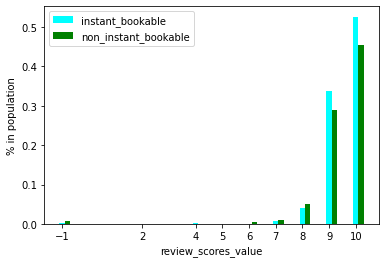

In [74]:
width = 0.2
x= non_instant_bookable_chart.review_scores_value 

# plot data in grouped manner of bar type
plt.bar(bar_df.review_scores_value, bar_df.reviews_per_month_x, width, color='cyan')
plt.bar(bar_df.review_scores_value+0.2, bar_df.reviews_per_month_y, width, color='green')
plt.xticks(bar_df.review_scores_value)
plt.xlabel("review_scores_value")
plt.ylabel("% in population")
plt.legend(["instant_bookable", "non_instant_bookable"])
plt.show()

### 2. What is the top 100 adjectives words in listing with good ratings

In [221]:
#define good reating
listings.review_scores_value.quantile(0.9)

10.0

In [222]:
good_listing=listings[listings.review_scores_value>=10]

In [223]:
good_review= good_listing.merge(reviews, left_on='id', right_on='listing_id',how='inner')

In [224]:
good_review.comments.shape[0]

45203

In [225]:
good_review['comments']=good_review['comments'].fillna('no_comment')

In [226]:
words_in_good_review=[]
for i in range(0, good_review.comments.shape[0]):
    word_list=good_review.comments[i].replace("\r\n\r\n", " ").split(' ')
    word_list_lower=list(map(str.lower,good_review.comments[i].replace("\r\n\r\n", " ").split(' ')))      
    for j in [ word for (word,tag) in nltk.pos_tag(word_list_lower) if tag == "JJ"] :
        words_in_good_review.append(re.sub('[^A-Za-z0-9]+', '', j))

In [227]:
good_word_counts=pd.DataFrame(pd.value_counts(np.array(words_in_good_review)),columns=['freq'])

In [228]:
data=good_word_counts.freq.head(100).to_dict()


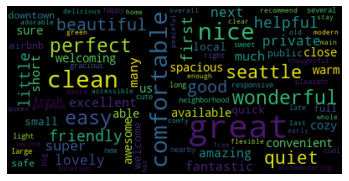

In [229]:
wordcloud = WordCloud(max_font_size=40,collocations=False).generate(" ".join([(k + ' ') * v for k,v in data.items()]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 3. What are the busiest times of the year to visit Seattle?

In [253]:
calendar.apply(lambda x: pd.isnull(x).value_counts())

,listing_id,date,available,price
False,1393570.0,1393570.0,1393570.0,934542
True,NaN,NaN,NaN,459028


In [254]:
#fillna for price
calendar[pd.isnull(calendar['price'])].available.unique()
calendar[~pd.isnull(calendar['price'])].available.unique()

#when the house is booked, the price is null. fillna with -1 as booked 
calendar['price']=calendar['price'].fillna(-1)

In [271]:
#booking rate by month 
calendar['year_month']=pd.to_datetime(calendar['date']).dt.strftime('%Y-%m') 
calendar['booked']=np.where(calendar['available']=='t',0,1)
calendar_agg=calendar.groupby(['year_month']).agg(total_date=('booked','count'),booked_date=('booked','sum')).reset_index()
calendar_agg['booked_rate']=calendar_agg['booked_date']/calendar_agg['total_date']

In [272]:
calendar_agg.sort_values(by='year_month')

,year_month,total_date,booked_date,booked_rate
0,2016-01,106904,47665,0.445867
1,2016-02,110722,37401,0.337792
2,2016-03,118358,34420,0.290813
3,2016-04,114540,38503,0.336153
4,2016-05,118358,38387,0.324330
5,2016-06,114540,37296,0.325616
6,2016-07,118358,44136,0.372903
7,2016-08,118358,42011,0.354949
8,2016-09,114540,37294,0.325598
9,2016-10,118358,35920,0.303486


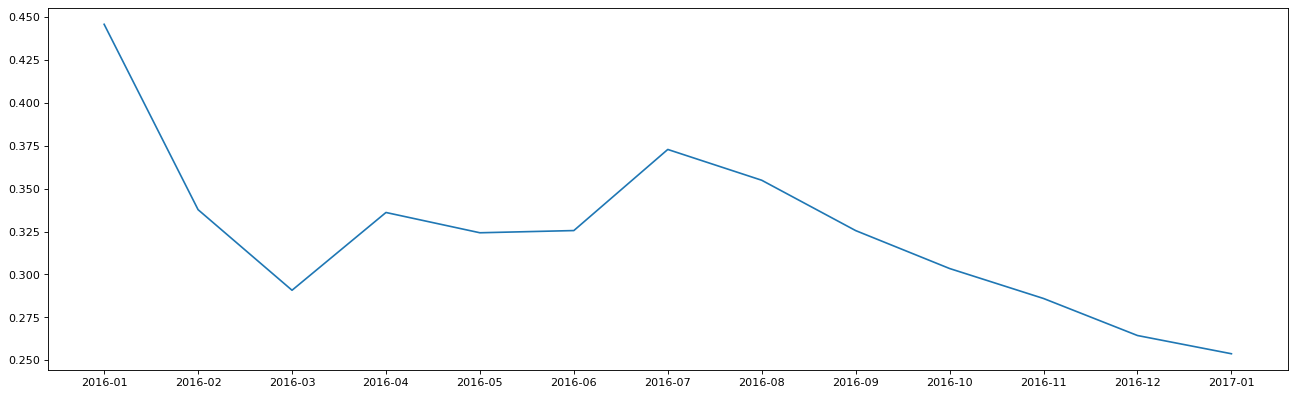

In [273]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)
plt.plot(calendar_agg.year_month,calendar_agg.booked_rate)
